# Kaggle's MNIST

## Initialization & imports

In [49]:
#import sys, itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from IPython.display import display, Markdown

## Pandas & seaborn config

In [22]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('chained_assignment', None)

sns.set(style="dark", palette="hls")

## CSV reading

In [23]:
print "Reading CSV..."
df = pd.read_csv("../data/input/train.csv")

Reading CSV...


## Features & labels

In [24]:
labels   = ['label']
features =  df.columns.drop(labels).values.tolist()

## Data exploration

In [25]:
display(Markdown("### Info"))
print df.info()
display(Markdown("### Null counts"))
print df.isnull().sum(axis=0).nonzero()

### Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


### Null counts

(array([], dtype=int64),)


## Image display function

In [26]:
def show_imgs(X, y, num=20):
    fig, axes = plt.subplots(1, num, figsize=(16,16))
    for i in range (0,num):
        label = y[i]
        img   = X.iloc[i].values.reshape(28,28)
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')

## Image exploration

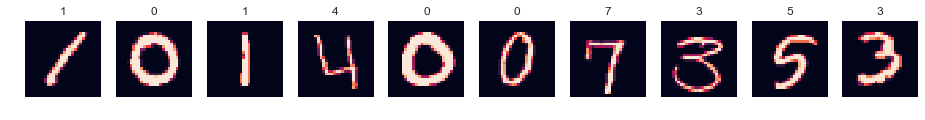

In [27]:
show_imgs(df.drop(columns=labels), df[labels].values.ravel(), 10)

## Preprocess

In [84]:
# Assigning
y = df[labels]
X = df.drop(columns=labels)

# Scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

# Color gradient flattening
#X = X.applymap(lambda x: 1 if x > 0 else 0)

### Testing

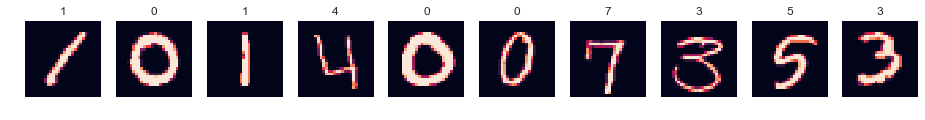

In [85]:
display(Markdown("### Testing"))
## Flattening of values

show_imgs(X, y.values.ravel(), 10)

## Splitting

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Classifier training + predictions & score + cross validation

In [82]:
print "Training classifier..."
clf = RandomForestClassifier(n_estimators=64, random_state=128)
clf.fit(X_train, y_train.values.ravel())
score = clf.score(X_test, y_test)
print "- Selected classifier accuracy:", score

print "Computing cross validated scores..."
scores = cross_val_score(clf, X, y.values.ravel(), cv=5)
print "- Cross validated accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), scores

y_pred = clf.predict(X_test)

Training classifier...
- Selected classifier accuracy: 0.9630952380952381
Computing cross validated scores...
- Cross validated accuracy: 0.96 (+/- 0.00) [0.96240333 0.96310841 0.96463865 0.96522568 0.96581706]


## Display image with predicted label

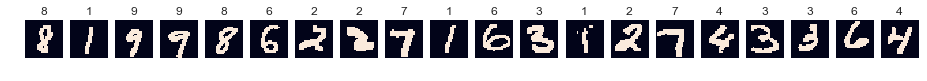

In [83]:
show_imgs(X_test, y_pred)

## Confusion matrix

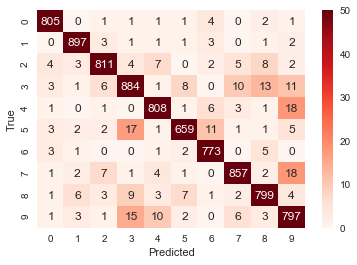

In [87]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt='d', vmax=50, cmap="Reds")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Display misclassifications

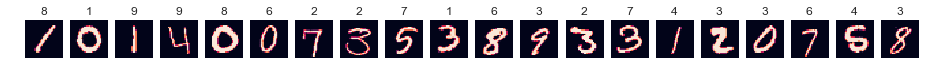

In [88]:
failed = []
for i, (truth, prediction, label) in enumerate(zip(y_test.values.ravel(), y_pred, y.values.ravel())):
    if prediction != label:
        failed.append(i)
df_fail = df.loc[failed].drop(labels, axis=1)

show_imgs(df_fail, y_pred[failed])

## Multiclass ROC curve & AUC

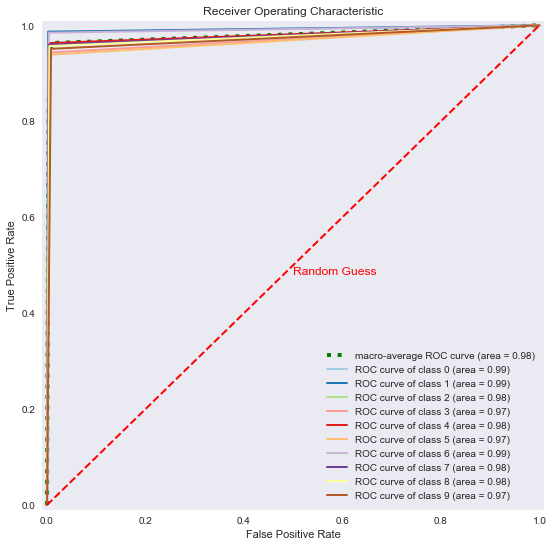

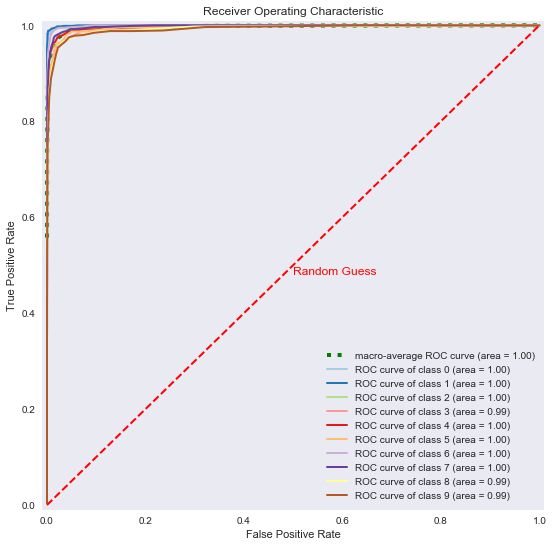

In [186]:
from scipy import interp
from itertools import cycle
from matplotlib import cm

def plot_multiclass_roc_curve(y_true, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2
    plt.figure(figsize=(9, 9))
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='green', linestyle=':', linewidth=4)

    colors = cycle(cm.Paired(np.linspace(0, 1, n_classes)))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

n_classes = len(clf.classes_)

y_pred_proba = clf.predict_proba(X_test)

y_true  = y_test.values.ravel()
y_true  = np.array(pd.get_dummies(y_true))

y_score = np.array(pd.get_dummies(y_pred))

plot_multiclass_roc_curve(y_true, y_score, n_classes)
plot_multiclass_roc_curve(y_true, y_pred_proba, n_classes)




